#  Step 1: Pulling out headlines from news API tickertick
Importing the packages required 

In [1]:
import requests
import json
from bs4 import BeautifulSoup

### Loading data from the API as a json file

In [2]:
# Use requests library to get the JSON data
JSONDATA = requests.request("GET", "https://api.tickertick.com/feed?q=(diff%20tx:ibm%20s:sec.gov)&lang=en&n=342") #Make sure you include the http part
# Load it with JSON 
data= JSONDATA.json()

In [3]:
data

{'stories': [{'id': '8732895747583029943',
   'title': 'IBM Business Partner Evanston Technology Partners & Cylera Announce New Solution to Help Hospitals Manage & Protect Ventilators & Other Critical Medical Devices in the Age of COVID-19',
   'url': 'https://www.biospace.com/article/releases/ibm-business-partner-evanston-technology-partners-and-amp-cylera-announce-new-solution-to-help-hospitals-manage-and-amp-protect-ventilators-and-amp-other-critical-medical-devices-in-the-age-of-covid-19/',
   'site': 'www.biospace.com',
   'time': 1587697798000,
   'favicon_url': 'https://www.biospace.com/assets/dist/images/appIcon-114x114.png;v=288623336c053a4b247b03248067fe41'},
  {'id': '7334540083096242939',
   'title': 'IBM First-Quarter Sales Decline as New CEO Aims to Revive Growth',
   'url': 'https://www.wsj.com/articles/ibm-first-quarter-sales-decline-as-new-ceo-aims-to-revive-growth-11587415010?mod=tech_listb_pos4',
   'site': 'www.wsj.com',
   'time': 1587513243000,
   'favicon_url': '

### Writing the required entities from json data in a csv file named "ibm_342_headlines.csv"

In [4]:
#opening a file
file_name="ibm_342_headlines.csv"
f=open(file_name,"w")
headers="headline,site,timestamp\n"

#Writing into a csv file
f.write(headers)
diff_news=data['stories']
for news in diff_news:
    headline=news['title']
    site=news['site']
    timestamp=news['time']
    f.write(headline.replace(",","|") +"," +site.replace(",","|") +"," + str(timestamp) +"\n")
f.close()

### Manipulating the data extracted in the csv file 
Importing the required packages first 

In [5]:
import pandas as pd
import csv
from textblob import TextBlob
import datetime

In [7]:
df=pd.read_csv("ibm_342_headlines.csv",sep=',',engine='python')
df.head()

,headline,site,timestamp
0,IBM Business Partner Evanston Technology Partn...,www.biospace.com,1587697798000
1,IBM First-Quarter Sales Decline as New CEO Aim...,www.wsj.com,1587513243000
2,IBM Reports Solid Profit but Won’t Forecast th...,www.barrons.com,1587463033000
3,IBM reports Q1 revenue of $17.6B| down 3.4% Yo...,www.cnbc.com,1587414820000
4,Nestlé Expands Use Of IBM Food Trust Blockchai...,www.forbes.com,1587248634000


#### Changing the date column and filtering data by the start and the end days 

In [8]:
df['Date']=df.apply(lambda x:datetime.datetime.fromtimestamp(x['timestamp']/1000).date(),axis=1)

#Filtering the headlines for a required period 
from datetime import datetime
start_date = datetime.strptime("2019-08-26",'%Y-%m-%d').date()
end_date = datetime.strptime("2020-04-24",'%Y-%m-%d').date()

after_start_date = df["Date"] >= start_date
before_end_date = df["Date"] <= end_date
between_two_dates = after_start_date & before_end_date
df = df.loc[between_two_dates] #dataframe with filtered dates

In [9]:
df.head()

,headline,site,timestamp,Date
0,IBM Business Partner Evanston Technology Partn...,www.biospace.com,1587697798000,2020-04-24
1,IBM First-Quarter Sales Decline as New CEO Aim...,www.wsj.com,1587513243000,2020-04-22
2,IBM Reports Solid Profit but Won’t Forecast th...,www.barrons.com,1587463033000,2020-04-21
3,IBM reports Q1 revenue of $17.6B| down 3.4% Yo...,www.cnbc.com,1587414820000,2020-04-21
4,Nestlé Expands Use Of IBM Food Trust Blockchai...,www.forbes.com,1587248634000,2020-04-19


### Adding features : polarity and subjectivity of each healine using textblob library of NLP
Adding the columns polarity , subjectivity and dropping the column timestamp from the dataset

In [10]:
df['polarity']=df.apply(lambda x:TextBlob(x['headline']).sentiment.polarity,axis=1)
df['subjectivity']=df.apply(lambda x:TextBlob(x['headline']).sentiment.subjectivity,axis=1)
df.drop(['timestamp'],axis=1,inplace=True)

Last five headlines of the data extracted

In [11]:
df.tail()

,headline,site,Date,polarity,subjectivity
335,Red Hat CEO Says Acquisition by IBM Will Help ...,www.wsj.com,2019-08-29,0.250000,0.250000
336,VMware And IBM Go Full Circle To Dominate The ...,www.forbes.com,2019-08-29,0.350000,0.550000
337,"Why IBM""s CIO values IT product design over ""e...",link.ciodive.com,2019-08-29,-0.500000,0.700000
338,VMware announces updates to its digital worksp...,www.zdnet.com,2019-08-28,0.068182,0.227273
339,IBM’s quantum-resistant magnetic tape storage ...,techcrunch.com,2019-08-28,0.000000,0.100000


### Checking whether the news headlines are for the right period 

In [13]:
print(df['Date'].min())
print(df['Date'].max())

2019-08-28
2020-04-24


In [14]:
#Date along with polarity and subjectivity for different headlines
x=df.groupby(by='Date').mean()
x.head()

,polarity,subjectivity
Date,,
2019-08-28,0.034091,0.163636
2019-08-29,0.033333,0.500000
2019-08-30,0.000000,0.000000
2019-08-31,0.000000,0.000000
2019-09-04,0.000000,0.750000


# Step 2: Pulling out the stock data for IBM using Alpha Vantage API

In [16]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt

alpha_vantage_api_key = "LWGQAEY9MIWZ91NX"

def pull_daily_time_series_alpha_vantage(alpha_vantage_api_key, ticker_name, output_size = "compact"):
   
    #Generate Alpha Vantage time series object
    ts = TimeSeries(key = alpha_vantage_api_key, output_format = 'pandas')
    data, meta_data = ts.get_daily_adjusted(ticker_name, outputsize = output_size)
    data['date_time'] = data.index
    return data, meta_data

ts_data, ts_metadata = pull_daily_time_series_alpha_vantage(alpha_vantage_api_key, ticker_name = "IBM",output_size="full") 

In [17]:
ts_data.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time
date,,,,,,,,,
2000-04-24,102.0,107.19,101.25,106.50,70.6851,8523100.0,0.0,1.0,2000-04-24
2000-04-25,106.5,113.00,106.44,112.50,74.6674,9576400.0,0.0,1.0,2000-04-25
2000-04-26,112.5,113.94,109.00,110.50,73.3399,6182800.0,0.0,1.0,2000-04-26
2000-04-27,109.5,113.12,108.69,110.62,73.4196,6317500.0,0.0,1.0,2000-04-27
2000-04-28,112.0,112.69,110.12,111.50,74.0037,4888600.0,0.0,1.0,2000-04-28


### Keeping the columns open,close,high,low and adjusted close along with the formattted date

In [18]:
#Dropping what is not required
ts_data.drop(columns=['7. dividend amount','8. split coefficient','6. volume'],inplace=True)

In [19]:
import datetime
ts_data.columns=['open','high','low','close','adjusted_close','date']
ts_data.reset_index(drop=True,inplace=True)
ts_data['date']=ts_data.apply(lambda x:x['date'].date(),axis=1)


In [20]:
ts_data.head()

,open,high,low,close,adjusted_close,date
0,102.0,107.19,101.25,106.50,70.6851,2000-04-24
1,106.5,113.00,106.44,112.50,74.6674,2000-04-25
2,112.5,113.94,109.00,110.50,73.3399,2000-04-26
3,109.5,113.12,108.69,110.62,73.4196,2000-04-27
4,112.0,112.69,110.12,111.50,74.0037,2000-04-28


In [21]:
#Start date and end date of stock data extracted from API
print(ts_data['date'].min())
print(ts_data['date'].max())

2000-04-24
2020-04-24


### Filtering the stock data for the required period

In [22]:
#Start date of the headlines and end date of the headlines
#2019-08-24
#2020-04-24

#Creating a dataset having the dates of headlines
from datetime import datetime
start_date = datetime.strptime("2019-08-28",'%Y-%m-%d').date()
end_date = datetime.strptime("2020-04-24",'%Y-%m-%d').date()

after_start_date = ts_data["date"] >= start_date
before_end_date = ts_data["date"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = ts_data.loc[between_two_dates]

In [24]:
filtered_dates.head()

,open,high,low,close,adjusted_close,date
4867,130.44,132.8900,130.0400,132.76,129.8450,2019-08-28
4868,134.18,135.6900,134.0400,134.88,131.9185,2019-08-29
4869,135.58,136.0700,134.3627,135.53,132.5542,2019-08-30
4870,134.85,134.9013,133.3301,134.10,131.1556,2019-09-03
4871,135.71,136.4300,135.1500,136.32,133.3268,2019-09-04


### Checking whether the stock data are for the right period 

In [25]:
print(filtered_dates['date'].min())
print(filtered_dates['date'].max())

2019-08-28
2020-04-24


# Step 3: Plotting the Stock data and news headlines' polarity ,subjectivity to check relevance 
Importing the packages for plotting

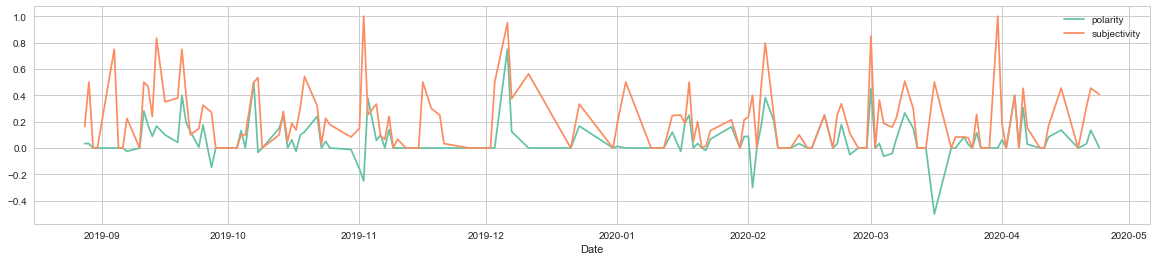

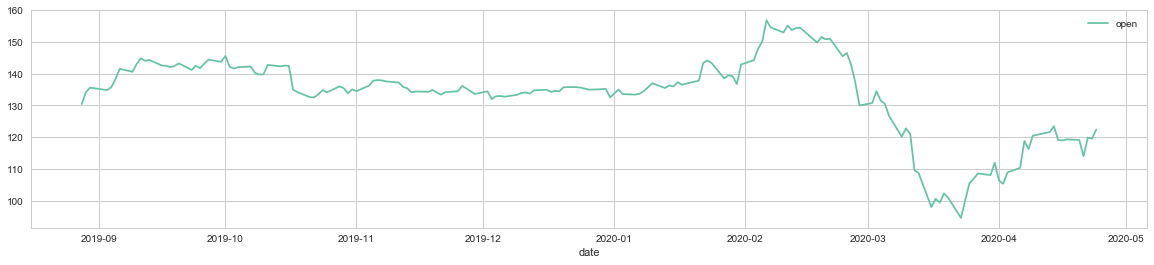

In [57]:
y=filtered_dates[['date','open']]
y=y.set_index('date')
# x has polarity and subjectivity news also
# y has the stock data
import seaborn as sns
sns.set(style="whitegrid",palette='Set2')
x.plot(figsize=(20,4),sharey=True)# headlines
y.plot(figsize=(20,4))# stock data

## Takeaways for the plots

1. The first graph shows polarity that is the sentiment using the headlines whether the price goes up or down or remains the same whereas the subjectivity in the orange shows how much confidence one can have on the predicted polarity <br></br>
2. The second graph shows the actual stock fluctuation according to the actual closing price data


## Efficiency and accuracy
The efficiency of the analysis seems to be quite good specially for a 8 months data.As you can see between the 2020-03 and 2020-04 the IBM stock crashes this is also predicted by the news just before it hits the rock bottom that too with very high subjectivity. 